# Overview:

In this project, we will build content-based classifiers to analyze the title text of online Newspaper articles.

We will use a large dataset from Kaggle, which scraped 210,000+ news articles from Huffington Post between 2012 to 2022: https://www.kaggle.com/datasets/rmisra/news-category-dataset

Our goal will be to generalize the classifier to a new, unlabelled dataset from BBC news: https://www.kaggle.com/datasets/gpreda/bbc-news

Steps:
1. Understanding the dataset
2. Text Preprocessing 
3. Binary Classification and generalization
4. Building a classifier on an imbalanced dataset
5. Hyperparameter tuning and generalization
6. Identify most common words in each class using LDA

## 1. Understanding the dataset

In [1]:
## Standard packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Text preprocessing
import spacy
nlp = spacy.load("en_core_web_sm") 
stopwords = spacy.lang.en.stop_words.STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

## Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Dimensionality Reduction
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE 
from sklearn.decomposition import LatentDirichletAllocation 

## Sklearn cross-validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

## Sklearn metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score

# GridSearch
from sklearn.model_selection import GridSearchCV

# Other
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight

df_raw = pd.read_json("News.json",lines=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [2]:
# this dataset is already cleaned, but let's drop duplicates in case
df_raw.head()
df_raw = df_raw[~df_raw.duplicated(subset="headline", keep='first')]
df_raw[df_raw.duplicated(subset="headline", keep='first')]

,link,headline,category,short_description,authors,date


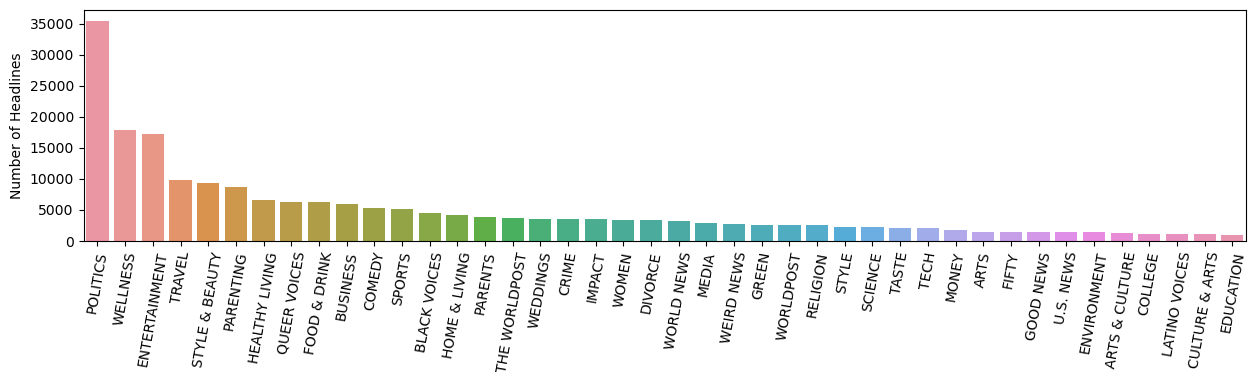

In [3]:
# Check the number of instances in each category
cat_list = df_raw.groupby("category")["category"].count().sort_values(ascending=False)

fig, ax = plt.subplots(1,1,figsize=(15,3))
sns.barplot(x=cat_list.index,y=cat_list.values)
plt.xticks(rotation=80)
plt.xlabel("")
plt.ylabel("Number of Headlines")
plt.show()

In [4]:
## As a baseline, lets build a binary classifier for Science vs Everything else, with even category labels
sci_df = df_raw[df_raw["category"] == "SCIENCE"].sample(2204,random_state=111)
other_df = df_raw[df_raw["category"] != "SCIENCE"].sample(2204,random_state=111)
other_df.loc[(other_df["category"] != "SCIENCE"),"category"] = "NOT SCIENCE"
df = sci_df.merge(other_df,how="outer")
display(df)

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/2013-come...,2013 Comets: Astronomers Prepare For Comet ISO...,SCIENCE,Many comets today are discovered by teams of o...,,2013-01-27
1,https://www.huffingtonpost.com/entry/spacex-ro...,SpaceX Rocket Crashes During Drone Ship Landin...,SCIENCE,On land: 1 for 1. At sea: 0 for 4.,Chris D'Angelo,2016-03-05
2,https://www.huffingtonpost.com/entry/enjoy-the...,Enjoy the Show: Learn More After 'Sharknado 2',SCIENCE,Hollywood blockbusters are not science documen...,"Dr. Ellen Prager and Carl Safina, Contributors",2014-07-27
3,https://www.huffingtonpost.com/entry/richard-i...,Bone Study Reveals Richard III Ate Like A King...,SCIENCE,,Ryan Grenoble,2014-08-17
4,https://www.huffingtonpost.com/entry/sleep-mem...,Scientists Can Detect Your Sleeptime Memories ...,SCIENCE,"Trying to learn Spanish while you nap, eh?",Bahar Gholipour,2016-08-29
...,...,...,...,...,...,...
4403,https://www.huffingtonpost.com/entry/online-ac...,Online Access To Patient Health Information Bo...,NOT SCIENCE,A new study is quelling any fears that online ...,,2012-11-20
4404,https://www.huffingtonpost.com/entry/los-angel...,How One Actress-Activist Is Working To End Dog...,NOT SCIENCE,Rebecca Corry hopes a new tip line will help l...,Joseph Erbentraut,2015-08-25
4405,https://www.huffingtonpost.com/entry/christian...,Louisiana Couple Cooks Barbecue For Entire She...,NOT SCIENCE,"""When you hand someone a serving tray of food,...",Elyse Wanshel,2016-08-18
4406,https://www.huffingtonpost.com/entry/prevent-a...,There May Be A Way To Prevent Anxiety Disorder...,NOT SCIENCE,Yet another reason to love therapy.,Lindsay Holmes,2015-09-29


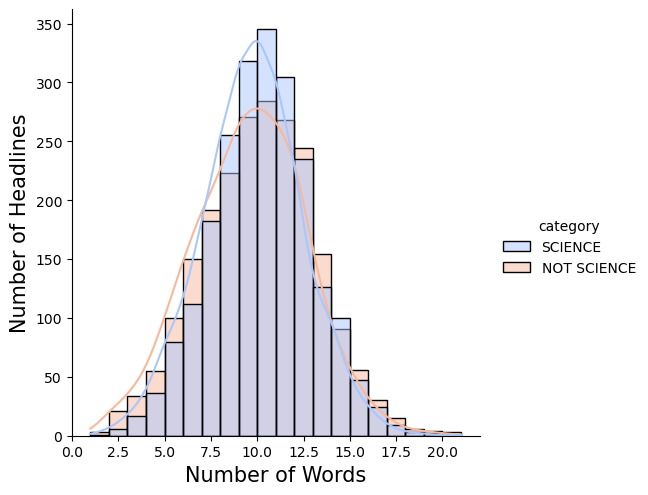

category
NOT SCIENCE    9.594374
SCIENCE        9.743194
Name: headline_count, dtype: float64

In [7]:
# check number of words in each category, the distribution seems similar overall
df["headline_count"] = df["headline"].str.split().str.len()
sns.displot(x=df["headline_count"],hue=df["category"],bins=20,kde=True,palette="coolwarm")
plt.ylabel("Number of Headlines",fontsize=15)
plt.xlabel("Number of Words",fontsize=15)
plt.show()

# obtain the mean, quite similar for both types of headlines
df.groupby("category")["headline_count"].mean()

In [10]:
## Load in the unlabelled dataset, and check the numberof words in the title and in the description
# In this demonstration, the guid contains the class label, but lets pretend this doesn't exist!
test_df = pd.read_csv("test_bbc_news.csv")
display(test_df)

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
20970,World Athletics Championships 2023: Great Brit...,"Sat, 19 Aug 2023 20:30:38 GMT",https://www.bbc.co.uk/sport/av/athletics/66560823,https://www.bbc.co.uk/sport/av/athletics/66560...,Watch as Great Britain win silver in the 4x400...
20971,Women's World Cup 2023: 'Who will England pick...,"Sat, 19 Aug 2023 14:14:04 GMT",https://www.bbc.co.uk/sport/av/football/66554135,https://www.bbc.co.uk/sport/av/football/665541...,"BBC Sport pundits Alex Scott, Fara Williams an..."
20972,Women's World Cup final: How England became go...,"Sat, 19 Aug 2023 12:45:42 GMT",https://www.bbc.co.uk/sport/football/66533140,https://www.bbc.co.uk/sport/football/66533140?...,More than 50 years after a ban on women's foot...
20973,Women's World Cup 2023: Lionesses tournament j...,"Sat, 19 Aug 2023 12:15:40 GMT",https://www.bbc.co.uk/sport/av/football/66554852,https://www.bbc.co.uk/sport/av/football/665548...,From reaching the quarter-finals in 1995 to se...


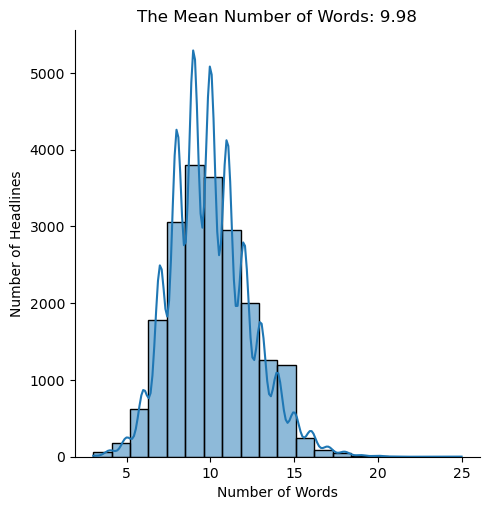

In [11]:
# obtain the mean count in the title, quite similar to the training set
test_df["headline_count"] = test_df["title"].str.split().str.len()
mean_test = test_df["headline_count"].mean()

sns.displot(x=test_df["headline_count"],bins=20,kde=True)
plt.ylabel("Number of Headlines")
plt.xlabel("Number of Words")
plt.title("The Mean Number of Words: {:.2f}".format(mean_test))
plt.show()

In [12]:
# Combine the datasets for text preprocessing
test_df = test_df.rename(columns={"title": "headline"})
test_df["category"] = "TEST"

tmp = [df, test_df]
comb_df = pd.concat(tmp)
display(comb_df)

,link,headline,category,short_description,authors,date,headline_count,pubDate,guid,description
0,https://www.huffingtonpost.com/entry/2013-come...,2013 Comets: Astronomers Prepare For Comet ISO...,SCIENCE,Many comets today are discovered by teams of o...,,2013-01-27,12,NaN,NaN,NaN
1,https://www.huffingtonpost.com/entry/spacex-ro...,SpaceX Rocket Crashes During Drone Ship Landin...,SCIENCE,On land: 1 for 1. At sea: 0 for 4.,Chris D'Angelo,2016-03-05,9,NaN,NaN,NaN
2,https://www.huffingtonpost.com/entry/enjoy-the...,Enjoy the Show: Learn More After 'Sharknado 2',SCIENCE,Hollywood blockbusters are not science documen...,"Dr. Ellen Prager and Carl Safina, Contributors",2014-07-27,8,NaN,NaN,NaN
3,https://www.huffingtonpost.com/entry/richard-i...,Bone Study Reveals Richard III Ate Like A King...,SCIENCE,,Ryan Grenoble,2014-08-17,13,NaN,NaN,NaN
4,https://www.huffingtonpost.com/entry/sleep-mem...,Scientists Can Detect Your Sleeptime Memories ...,SCIENCE,"Trying to learn Spanish while you nap, eh?",Bahar Gholipour,2016-08-29,10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
20970,https://www.bbc.co.uk/sport/av/athletics/66560...,World Athletics Championships 2023: Great Brit...,TEST,NaN,NaN,NaT,16,"Sat, 19 Aug 2023 20:30:38 GMT",https://www.bbc.co.uk/sport/av/athletics/66560823,Watch as Great Britain win silver in the 4x400...
20971,https://www.bbc.co.uk/sport/av/football/665541...,Women's World Cup 2023: 'Who will England pick...,TEST,NaN,NaN,NaT,11,"Sat, 19 Aug 2023 14:14:04 GMT",https://www.bbc.co.uk/sport/av/football/66554135,"BBC Sport pundits Alex Scott, Fara Williams an..."
20972,https://www.bbc.co.uk/sport/football/66533140?...,Women's World Cup final: How England became go...,TEST,NaN,NaN,NaT,11,"Sat, 19 Aug 2023 12:45:42 GMT",https://www.bbc.co.uk/sport/football/66533140,More than 50 years after a ban on women's foot...
20973,https://www.bbc.co.uk/sport/av/football/665548...,Women's World Cup 2023: Lionesses tournament j...,TEST,NaN,NaN,NaT,12,"Sat, 19 Aug 2023 12:15:40 GMT",https://www.bbc.co.uk/sport/av/football/66554852,From reaching the quarter-finals in 1995 to se...


## 2. Text Preprocessing

1. Tokenization (convert to single words)
2. Lemmatization (convert words to base form)
3. Removing non-alphabetic and stop words
4. Visualize the classes using dimensionality reduction

In [13]:
# Get individual tokens, keep alphanumeric characters, lemmatization, and remove stop words
headlines = []
for doc in nlp.pipe(comb_df["headline"].tolist()):
    lemmas = [
        token.lemma_ for token in doc
        if token.lemma_.isalpha() and token.lemma_ not in stopwords
        ]     
    headlines.append(" ".join(lemmas))

df_headlines = comb_df[["headline","category"]]
df_headlines = df_headlines.assign(headline_lemma=headlines)
display(df_headlines)

,headline,category,headline_lemma
0,2013 Comets: Astronomers Prepare For Comet ISO...,SCIENCE,comet astronomer prepare Comet ison Pan STARRS...
1,SpaceX Rocket Crashes During Drone Ship Landin...,SCIENCE,SpaceX Rocket Crashes Drone Ship Landing
2,Enjoy the Show: Learn More After 'Sharknado 2',SCIENCE,enjoy learn More Sharknado
3,Bone Study Reveals Richard III Ate Like A King...,SCIENCE,bone Study reveal Richard III eat like King Dr...
4,Scientists Can Detect Your Sleeptime Memories ...,SCIENCE,scientist detect Sleeptime Memories
...,...,...,...
20970,World Athletics Championships 2023: Great Brit...,TEST,World Athletics Championships Great Britain wi...
20971,Women's World Cup 2023: 'Who will England pick...,TEST,Women World Cup England pick final
20972,Women's World Cup final: How England became go...,TEST,Women World Cup final England good woman football
20973,Women's World Cup 2023: Lionesses tournament j...,TEST,Women World Cup lioness tournament journey pre...


In [14]:
# Visualize some examples
pd.set_option('display.max_colwidth', None)
df_headlines[df_headlines["category"] == "SCIENCE"].sample(n=5,random_state = 999)

,headline,category,headline_lemma
68,The Little Question That Fueled Actor's Big Push For Plain-Spoken Science,SCIENCE,Little Question Fueled Actor big Push Plain Spoken Science
665,NASA’s Juno Spacecraft Sent Back Some Spectacular Shots Of Jupiter,SCIENCE,NASA Juno Spacecraft send Spectacular shot Jupiter
1510,A sea slug changed my life,SCIENCE,sea slug change life
559,Why We Feel Others' Pain -- or Don't,SCIENCE,feel pain
1735,Bill Nye Yearbook PHOTO? Popular 'Science Guy' Had A Thing For Bow Ties In High School,SCIENCE,Bill Nye Yearbook photo Popular Science Guy thing Bow Ties High School


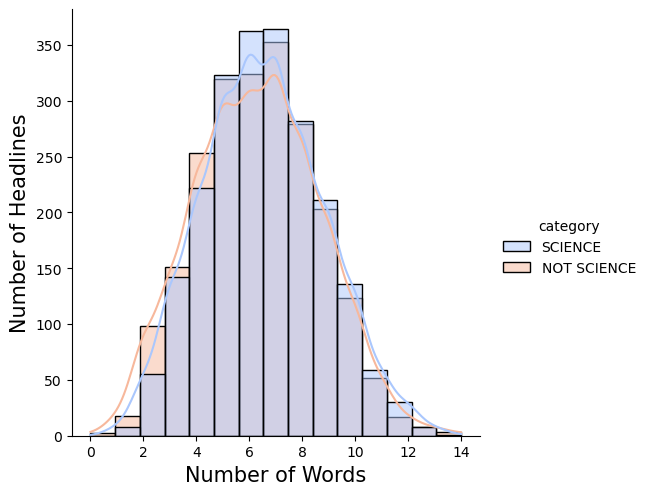

category
NOT SCIENCE    6.308984
SCIENCE        6.540381
Name: headline_count, dtype: float64

In [15]:
# check number of words in each category, after preprocessing
df_headlines["headline_count"] = df_headlines["headline_lemma"].str.split().str.len()
df_headlines_tp = df_headlines[df_headlines["category"] != "TEST"]
sns.displot(x=df_headlines_tp["headline_count"],hue=df_headlines_tp["category"],bins=15,kde=True,palette="coolwarm")
plt.ylabel("Number of Headlines",fontsize=15)
plt.xlabel("Number of Words",fontsize=15)
plt.show()

# obtain the mean, quite similar for both types of headlines
df_headlines_tp.groupby("category")["headline_count"].mean()

In [12]:
# Construct a TF-IDF matrix for headlines, but then keep only the training set
tfidf = TfidfVectorizer(lowercase=True)
tfidf_all = tfidf.fit_transform(df_headlines['headline_lemma'].to_numpy())
tfidf_train = tfidf_all[:4408,:] # keep on the rows corresponding to our labelled data
dense_array = np.asarray(tfidf_train.todense())

# PCA to visualize the tfidf matrix
pca = PCA(n_components=2)
tfidf_train_pca2D = pca.fit_transform(dense_array)
df_pca2D = pd.DataFrame(tfidf_train_pca2D, columns=["d1","d2"])
df_pca2D = df_pca2D.assign(category = df["category"])

# Truncated SVD to visualize the tfidf matrix (might better capture the sparsity of the matrix)
svd = TruncatedSVD(n_components=2)
tfidf_train_svd2D = svd.fit_transform(dense_array)
df_svd2D = pd.DataFrame(tfidf_train_svd2D, columns = ["d1","d2"])
df_svd2D = df_svd2D.assign(category = df["category"])

# TSNE might best visualize the matrix, given the nonlinear clustering algorithm
tsne = TSNE(n_components=2)
tfidf_train_tsne2D = svd.fit_transform(dense_array)
df_tsne2D = pd.DataFrame(tfidf_train_tsne2D, columns = ["d1","d2"])
df_tsne2D = df_tsne2D.assign(category = df["category"])

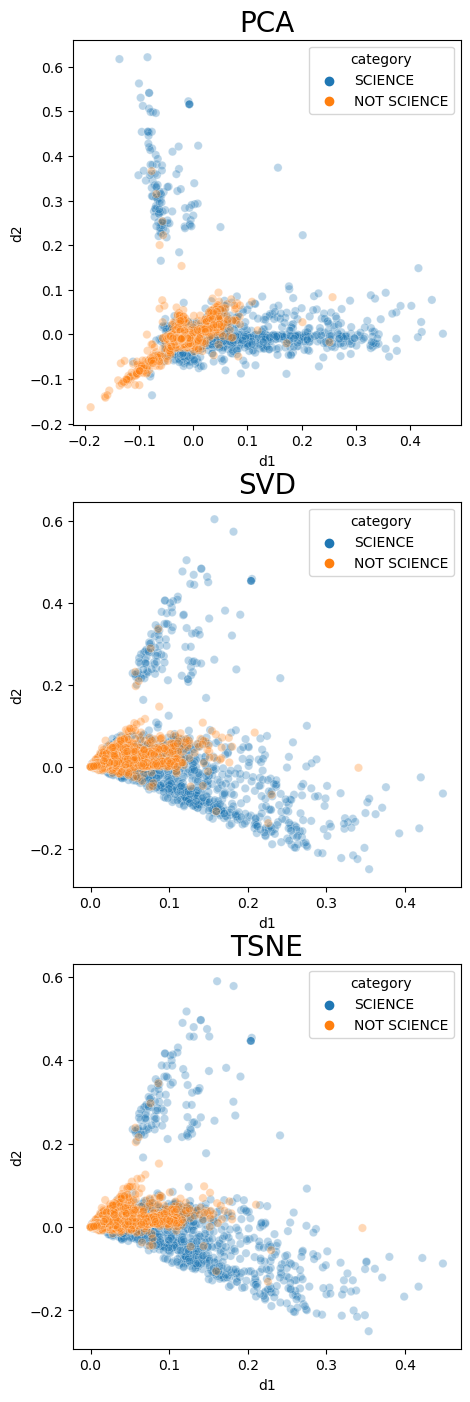

In [13]:
# Visualize Clustering Algorithms
fig, ax = plt.subplots(3,1,figsize=(5,17))
sns.scatterplot(x="d1",y="d2",data=df_pca2D,hue="category",alpha=0.3,ax=ax[0])
sns.scatterplot(x="d1",y="d2",data=df_svd2D,hue="category",alpha=0.3,ax=ax[1])
sns.scatterplot(x="d1",y="d2",data=df_tsne2D,hue="category",alpha=0.3,ax=ax[2])
ax[0].set_title("PCA",fontsize=20)
ax[1].set_title("SVD",fontsize=20)
ax[2].set_title("TSNE",fontsize=20)
plt.show()

### Interim Notes
- After preprocessing, each title only has ~6-7 words
- Science Articles comprise a minority of the dataset
- All clustering algorithms seperates the two categories well. For this reason, the classifier is likely to be successful for a dataset with equal category labels

## 3. Binary Classification

In [14]:
# Split data into training and testing samples
X = tfidf_train
y = df["category"]

# Define the classifiers
dt = DecisionTreeClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()
nb = MultinomialNB()
rf = RandomForestClassifier()
svm = SVC()

classifiers = [
    ("Decision Tree", dt),
    ("Logistic Regression", lr),
    ("KNN", knn),
    ("Naive Bayes", nb),
    ("Random Forest", rf),
    ("SVM", svm)
]

# Iterate over the pre-defined list of classifiers
conf = []
acc = []
for clf_name, clf in classifiers:    
     
    y_pred = cross_val_predict(clf, X, y, cv = 10, n_jobs = -1)
    conf.append(confusion_matrix(y,y_pred))
    acc.append(accuracy_score(y, y_pred))
    print(clf_name)
    print(classification_report(y, y_pred, labels=np.unique(y_pred)))

Decision Tree
              precision    recall  f1-score   support

 NOT SCIENCE       0.78      0.84      0.81      2204
     SCIENCE       0.83      0.77      0.79      2204

    accuracy                           0.80      4408
   macro avg       0.80      0.80      0.80      4408
weighted avg       0.80      0.80      0.80      4408

Logistic Regression
              precision    recall  f1-score   support

 NOT SCIENCE       0.80      0.94      0.86      2204
     SCIENCE       0.92      0.77      0.84      2204

    accuracy                           0.85      4408
   macro avg       0.86      0.85      0.85      4408
weighted avg       0.86      0.85      0.85      4408

KNN
              precision    recall  f1-score   support

 NOT SCIENCE       0.71      0.91      0.79      2204
     SCIENCE       0.87      0.62      0.73      2204

    accuracy                           0.76      4408
   macro avg       0.79      0.76      0.76      4408
weighted avg       0.79      0.76   

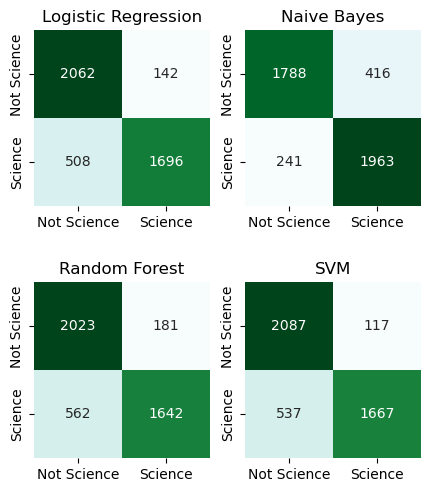

In [15]:
## 2. Logistic Regression, 4. Naive Bayes, 5. Random Forest, and 6. SVM all performed well
# Plot all confusion matrices
conf_array = pd.DataFrame(np.concatenate(conf, axis=0))
lr_cm = conf_array.iloc[2:4,:]
nb_cm = conf_array.iloc[6:8,:]
rf_cm = conf_array.iloc[8:10,:]
svm_cm = conf_array.iloc[10:12,:]

fig, ax = plt.subplots(2,2,figsize=(5,6))
sns.heatmap(lr_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[0,0])
ax[0,0].set_xticklabels(["Not Science","Science"])
ax[0,0].set_yticklabels(["Not Science","Science"])
ax[0,0].set_title("Logistic Regression")
sns.heatmap(nb_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[0,1])
ax[0,1].set_xticklabels(["Not Science","Science"])
ax[0,1].set_yticklabels(["Not Science","Science"])
ax[0,1].set_title("Naive Bayes")
sns.heatmap(rf_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[1,0])
ax[1,0].set_xticklabels(["Not Science","Science"])
ax[1,0].set_yticklabels(["Not Science","Science"])
ax[1,0].set_title("Random Forest")
sns.heatmap(svm_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[1,1])
ax[1,1].set_xticklabels(["Not Science","Science"])
ax[1,1].set_yticklabels(["Not Science","Science"])
ax[1,1].set_title("SVM")
plt.show()

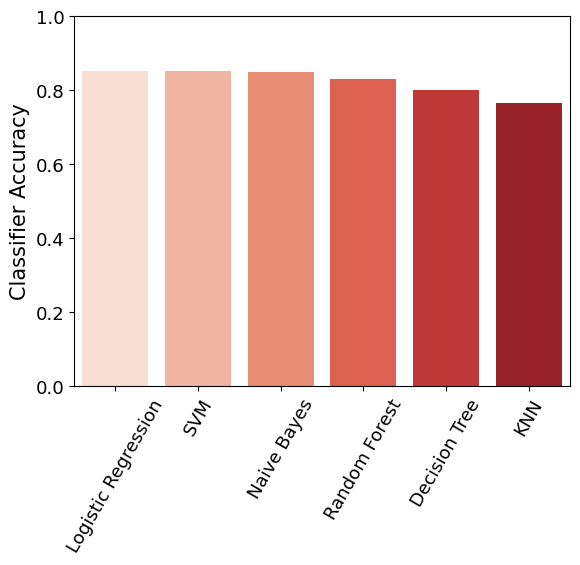

In [16]:
classifiers = [
    "Decision Tree",
    "Logistic Regression",
    "KNN",
    "Naive Bayes",
    "Random Forest",
    "SVM"
]

acc_df = pd.DataFrame(zip(classifiers,acc),columns=["Classifier","Accuracy"])
acc_df = acc_df.sort_values("Accuracy",ascending=False)

sns.barplot(x="Classifier",y="Accuracy",data=acc_df, palette="Reds")
plt.ylim(0,1)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13,rotation=60)
plt.xlabel("")
plt.ylabel("Classifier Accuracy", fontsize=15)
plt.show()

In [30]:
df_test = comb_df[comb_df["category"] == "TEST"]
df_test = df_test[["headline","link",]]

In [31]:
## Use the Logistic Regression Classifier to test on our unlabelled dataset
tfidf = TfidfVectorizer(lowercase=True)
tfidf_all = tfidf.fit_transform(df_headlines['headline_lemma'].to_numpy())
tfidf_train = tfidf_all[:4408,:] # keep on the rows corresponding to our labelled data
tfidf_test = tfidf_all[4408:,:] # keep on the rows corresponding to our unlabelled data

lr = LogisticRegression()
X_train = tfidf_train
y_train = df["category"]
X_test = tfidf_test

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

df_test["predict"] = y_pred

In [34]:
# The results seem ok, but not perfect. Let's try with an imbalanced dataset
science_df = df_test[df_test["predict"] == "SCIENCE"]
science_df = science_df[["headline","link","predict"]]
pd.set_option('display.max_colwidth', None)
science_df.sample(n=10,random_state=1)

,headline,link,predict
15710,"'Universal' cancer cure unlikely at present, study reveals",https://www.bbc.co.uk/news/health-65252510?at_medium=RSS&at_campaign=KARANGA,SCIENCE
17888,Succession actor Brian Cox on why he hasn't watched finale,https://www.bbc.co.uk/news/entertainment-arts-65803015?at_medium=RSS&at_campaign=KARANGA,SCIENCE
20086,Hiccupping giant panda caught on camera,https://www.bbc.co.uk/news/world-asia-china-66372950?at_medium=RSS&at_campaign=KARANGA,SCIENCE
14277,Human error to blame for train crash - Greek PM,https://www.bbc.co.uk/news/world-europe-64817894?at_medium=RSS&at_campaign=KARANGA,SCIENCE
7159,Hold Me Closer: Britney Spears releases first new music since 2016,https://www.bbc.co.uk/news/entertainment-arts-62680081?at_medium=RSS&at_campaign=KARANGA,SCIENCE
12668,Ukraine war: Soledar devastation revealed in satellite images,https://www.bbc.co.uk/news/world-europe-64250202?at_medium=RSS&at_campaign=KARANGA,SCIENCE
5503,Missile strike on Ukraine space plant in Dnipro kills three,https://www.bbc.co.uk/news/world-europe-62189844?at_medium=RSS&at_campaign=KARANGA,SCIENCE
6300,Commonwealth Games: 'An education in what esports actually is',https://www.bbc.co.uk/news/newsbeat-62427420?at_medium=RSS&at_campaign=KARANGA,SCIENCE
18046,Watch: Water gushes through dam,https://www.bbc.co.uk/news/world-europe-65818715?at_medium=RSS&at_campaign=KARANGA,SCIENCE
14920,Miss Wales says she is grateful after life-changing M4 crash,https://www.bbc.co.uk/news/uk-wales-64981797?at_medium=RSS&at_campaign=KARANGA,SCIENCE


## 4. Training on an Imbalanced Dataset

In [16]:
## Lets create a 1:10 dataset
ib_sci_df = df_raw[df_raw["category"] == "SCIENCE"].sample(2204,random_state=111)
ib_other_df = df_raw[df_raw["category"] != "SCIENCE"].sample(19836,random_state=111)
ib_other_df.loc[(ib_other_df["category"] != "SCIENCE"),"category"] = "NOT SCIENCE"
df_ib = ib_sci_df.merge(ib_other_df,how="outer")
display(df_ib)

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/2013-comets-astronomers-comet-ison_us_5baeb475e4b014374e2e1703,"2013 Comets: Astronomers Prepare For Comet ISON, Pan-STARRS In 'Year Of Comets'",SCIENCE,"Many comets today are discovered by teams of observers, which has started a trend to name these discoveries for the project",,2013-01-27
1,https://www.huffingtonpost.com/entry/spacex-rocket-crash_us_56da1b14e4b0000de404c7f5,SpaceX Rocket Crashes During Drone Ship Landing -- Again,SCIENCE,On land: 1 for 1. At sea: 0 for 4.,Chris D'Angelo,2016-03-05
2,https://www.huffingtonpost.com/entry/enjoy-the-show-learn-more_b_5623420.html,Enjoy the Show: Learn More After 'Sharknado 2',SCIENCE,"Hollywood blockbusters are not science documentaries nor do they pretend to be, they are pure entertainment that recognizes the interest and fascination people have with nature, natural disasters, and the Earth.","Dr. Ellen Prager and Carl Safina, Contributors",2014-07-27
3,https://www.huffingtonpost.com/entry/richard-iii-bone-study-king_n_5685773.html,"Bone Study Reveals Richard III Ate Like A King, Drank Like A Fish",SCIENCE,,Ryan Grenoble,2014-08-17
4,https://www.huffingtonpost.com/entry/sleep-memories-study_us_57c46444e4b0664f13c99c98,Scientists Can Detect Your Sleeptime Memories Even If You Can’t,SCIENCE,"Trying to learn Spanish while you nap, eh?",Bahar Gholipour,2016-08-29
...,...,...,...,...,...,...
22035,https://www.huffingtonpost.com/entry/marco-rubio-deferred-action-for-childhood-arrivals_us_563a592be4b0411d306f42cd,Marco Rubio Says He'd End Protections For Dreamers Even Without Immigration Reform,NOT SCIENCE,He's been getting grief for saying he wouldn't end it immediately.,Elise Foley,2015-11-04
22036,https://www.huffingtonpost.com/entry/orange-county-serial-killer-jailhouse-informant_us_5a3d98cee4b06d1621b45d8d,How To Get Back To The Streets If You're A Serial Killer In Orange County,NOT SCIENCE,"Oscar Moriel was facing life in prison, but his controversial work as an informant dramatically reduced his sentence.",Matt Ferner,2017-12-23
22037,https://www.huffingtonpost.com/entry/valentines-day-relationships_us_5b9cccc9e4b03a1dcc81fa04,Amplify the Romance in Your Relationship: Advice for Valentine's Day,NOT SCIENCE,"One reason Valentine's Day tends to be so romantic is that we think outside the box and break our usual habits. Anything from going out to dinner to planning a short trip can enliven us. When we are open to new experiences, we resist the lure of doing what's familiar, therefore losing our spontaneity.","Lisa Firestone, Contributor\nPsychology expert on relationships, parenting, self-destructiv...",2013-02-12
22038,https://www.huffingtonpost.com/entry/moving-on-after-loss-_b_5195790.html,Why 'Getting Over It' Is A Myth You Should Ignore,NOT SCIENCE,"I had been widowed just over a year and well into my own Healing Journey when my mother gave me some very wise advice (which I both follow and dole out to this day). She told me to stop and look back at how far I had progressed since that awful season in time when my husband passed away. When I actually took the time to stop and examine how far I had progressed to that point (and have progressed since that time many years ago), I started worrying less about being ""over it"" and started appreciating the healing that I had accomplished instead.","Carole Brody Fleet, ContributorSpeaker, Media Contributor and Award-Winning Author, ""When Bad...",2014-04-28


In [17]:
## Science headlines are now highly imbalanced!
counts = df_ib.groupby("category")["category"].count()
sci_prop = (1 - (counts[0]/(counts[0]+counts[1])))*100
print("Science headlines comprise {:,.2f}% of our dataset".format(sci_prop))

Science headlines comprise 10.00% of our dataset


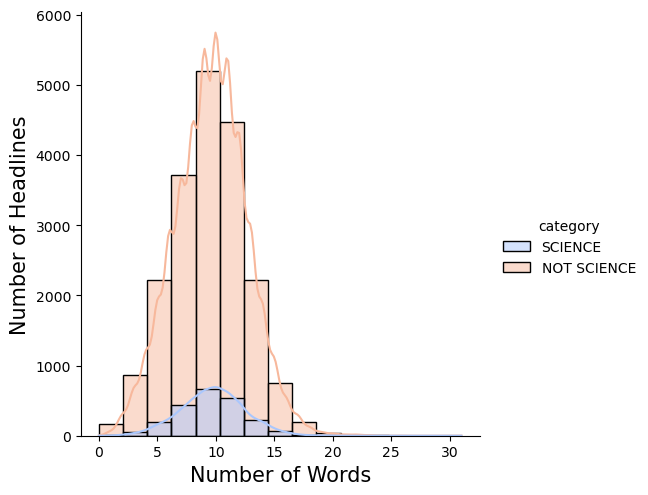

category
NOT SCIENCE    9.583585
SCIENCE        9.743194
Name: headline_count, dtype: float64

In [18]:
# check number of words in each category, the distribution seems similar overall
df_ib["headline_count"] = df_ib["headline"].str.split().str.len()
df_ib_tp = df_ib[df_ib["category"] != "TEST"]

# check number of words in each category, after preprocessing
sns.displot(x=df_ib_tp["headline_count"],hue=df_ib_tp["category"],bins=15,kde=True,palette="coolwarm")
plt.ylabel("Number of Headlines",fontsize=15)
plt.xlabel("Number of Words",fontsize=15)
plt.show()

# obtain the mean, quite similar for both types of headlines
df_ib_tp.groupby("category")["headline_count"].mean()

# obtain the mean, quite similar for both types of headlines
df_ib_tp.groupby("category")["headline_count"].mean()

In [19]:
tmp = [df_ib, test_df]
comb_df = pd.concat(tmp)
display(comb_df)

,link,headline,category,short_description,authors,date,headline_count,pubDate,guid,description
0,https://www.huffingtonpost.com/entry/2013-comets-astronomers-comet-ison_us_5baeb475e4b014374e2e1703,"2013 Comets: Astronomers Prepare For Comet ISON, Pan-STARRS In 'Year Of Comets'",SCIENCE,"Many comets today are discovered by teams of observers, which has started a trend to name these discoveries for the project",,2013-01-27,12,NaN,NaN,NaN
1,https://www.huffingtonpost.com/entry/spacex-rocket-crash_us_56da1b14e4b0000de404c7f5,SpaceX Rocket Crashes During Drone Ship Landing -- Again,SCIENCE,On land: 1 for 1. At sea: 0 for 4.,Chris D'Angelo,2016-03-05,9,NaN,NaN,NaN
2,https://www.huffingtonpost.com/entry/enjoy-the-show-learn-more_b_5623420.html,Enjoy the Show: Learn More After 'Sharknado 2',SCIENCE,"Hollywood blockbusters are not science documentaries nor do they pretend to be, they are pure entertainment that recognizes the interest and fascination people have with nature, natural disasters, and the Earth.","Dr. Ellen Prager and Carl Safina, Contributors",2014-07-27,8,NaN,NaN,NaN
3,https://www.huffingtonpost.com/entry/richard-iii-bone-study-king_n_5685773.html,"Bone Study Reveals Richard III Ate Like A King, Drank Like A Fish",SCIENCE,,Ryan Grenoble,2014-08-17,13,NaN,NaN,NaN
4,https://www.huffingtonpost.com/entry/sleep-memories-study_us_57c46444e4b0664f13c99c98,Scientists Can Detect Your Sleeptime Memories Even If You Can’t,SCIENCE,"Trying to learn Spanish while you nap, eh?",Bahar Gholipour,2016-08-29,10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
20970,https://www.bbc.co.uk/sport/av/athletics/66560823?at_medium=RSS&at_campaign=KARANGA,World Athletics Championships 2023: Great Britain win silver in 4x400m mixed relay after Femke Boll trips,TEST,NaN,NaN,NaT,16,"Sat, 19 Aug 2023 20:30:38 GMT",https://www.bbc.co.uk/sport/av/athletics/66560823,Watch as Great Britain win silver in the 4x400m mixed relay final after Netherlands' Femke Bol falls in the final few yards at the World Athletics Championships.
20971,https://www.bbc.co.uk/sport/av/football/66554135?at_medium=RSS&at_campaign=KARANGA,Women's World Cup 2023: 'Who will England pick for the final?',TEST,NaN,NaN,NaT,11,"Sat, 19 Aug 2023 14:14:04 GMT",https://www.bbc.co.uk/sport/av/football/66554135,"BBC Sport pundits Alex Scott, Fara Williams and Ellen White discuss whether Lauren James should be recalled to England's starting line-up for the Women's World Cup final against Spain."
20972,https://www.bbc.co.uk/sport/football/66533140?at_medium=RSS&at_campaign=KARANGA,Women's World Cup final: How England became good at women’s football,TEST,NaN,NaN,NaT,11,"Sat, 19 Aug 2023 12:45:42 GMT",https://www.bbc.co.uk/sport/football/66533140,"More than 50 years after a ban on women's football was lifted, England are in to the World Cup final - but how did we get here?"
20973,https://www.bbc.co.uk/sport/av/football/66554852?at_medium=RSS&at_campaign=KARANGA,Women's World Cup 2023: Lionesses tournament journey from 1995 to present day,TEST,NaN,NaN,NaT,12,"Sat, 19 Aug 2023 12:15:40 GMT",https://www.bbc.co.uk/sport/av/football/66554852,"From reaching the quarter-finals in 1995 to securing a spot in this year's final, we look back at the Lionesses' World Cup journey."


In [20]:
# Get individual tokens, lemmatization, undercase, and remove stop words
headlines = []
for doc in nlp.pipe(comb_df["headline"].tolist()):
    lemmas = [
        token.lemma_ for token in doc
        if token.lemma_.isalpha() and token.lemma_ not in stopwords
        ]     
    headlines.append(" ".join(lemmas))

im_df_headlines = comb_df[["headline","category"]]
im_df_headlines = im_df_headlines.assign(headline_lemma=headlines)
display(im_df_headlines)

,headline,category,headline_lemma
0,"2013 Comets: Astronomers Prepare For Comet ISON, Pan-STARRS In 'Year Of Comets'",SCIENCE,comet astronomer prepare Comet ison Pan STARRS Year comet
1,SpaceX Rocket Crashes During Drone Ship Landing -- Again,SCIENCE,SpaceX Rocket Crashes Drone Ship Landing
2,Enjoy the Show: Learn More After 'Sharknado 2',SCIENCE,enjoy learn More Sharknado
3,"Bone Study Reveals Richard III Ate Like A King, Drank Like A Fish",SCIENCE,bone Study reveal Richard III eat like King Drank like fish
4,Scientists Can Detect Your Sleeptime Memories Even If You Can’t,SCIENCE,scientist detect Sleeptime Memories
...,...,...,...
20970,World Athletics Championships 2023: Great Britain win silver in 4x400m mixed relay after Femke Boll trips,TEST,World Athletics Championships Great Britain win silver m mixed relay Femke Boll trip
20971,Women's World Cup 2023: 'Who will England pick for the final?',TEST,Women World Cup England pick final
20972,Women's World Cup final: How England became good at women’s football,TEST,Women World Cup final England good woman football
20973,Women's World Cup 2023: Lionesses tournament journey from 1995 to present day,TEST,Women World Cup lioness tournament journey present day


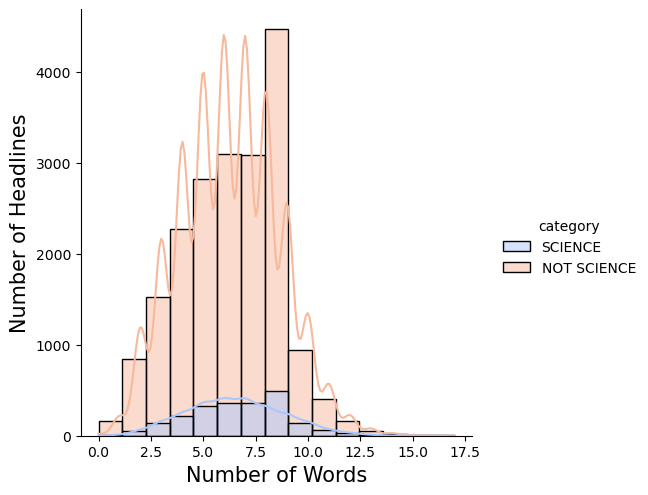

category
NOT SCIENCE    6.258217
SCIENCE        6.540381
Name: headline_count, dtype: float64

In [21]:
# check number of words in each category, after preprocessing
im_df_headlines["headline_count"] = im_df_headlines["headline_lemma"].str.split().str.len()
im_df_headlines_tp = im_df_headlines[im_df_headlines["category"] != "TEST"]

# check number of words in each category, after preprocessing
sns.displot(x=im_df_headlines_tp["headline_count"],hue=im_df_headlines_tp["category"],bins=15,kde=True,palette="coolwarm")
plt.ylabel("Number of Headlines",fontsize=15)
plt.xlabel("Number of Words",fontsize=15)
plt.show()

# obtain the mean, quite similar for both types of headlines
im_df_headlines_tp.groupby("category")["headline_count"].mean()

In [24]:
# Construct a TF-IDF matrix for headlines, but then keep only the training set
tfidf = TfidfVectorizer(lowercase=True)
tfidf_all = tfidf.fit_transform(im_df_headlines['headline_lemma'].to_numpy())
tfidf_train = tfidf_all[:22040,:] # keep only the rows corresponding to our labelled data
dense_array = np.asarray(tfidf_train.todense())

# PCA to visualize the tfidf matrix
pca = PCA(n_components=2)
tfidf_all_pca2D = pca.fit_transform(dense_array)
df_pca2D = pd.DataFrame(tfidf_all_pca2D, columns=["d1","d2"])
df_pca2D = df_pca2D.assign(category = df_ib["category"])

# Truncated SVD to visualize the tfidf matrix (might better capture the sparsity of the matrix)
svd = TruncatedSVD(n_components=2)
tfidf_all_svd2D = svd.fit_transform(dense_array)
df_svd2D = pd.DataFrame(tfidf_all_svd2D, columns = ["d1","d2"])
df_svd2D = df_svd2D.assign(category = df_ib["category"])

# TSNE might best visualize the matrix, given the nonlinear clustering algorithm
tsne = TSNE(n_components=2)
tfidf_all_tsne2D = svd.fit_transform(dense_array)
df_tsne2D = pd.DataFrame(tfidf_all_tsne2D, columns = ["d1","d2"])
df_tsne2D = df_tsne2D.assign(category = df_ib["category"])

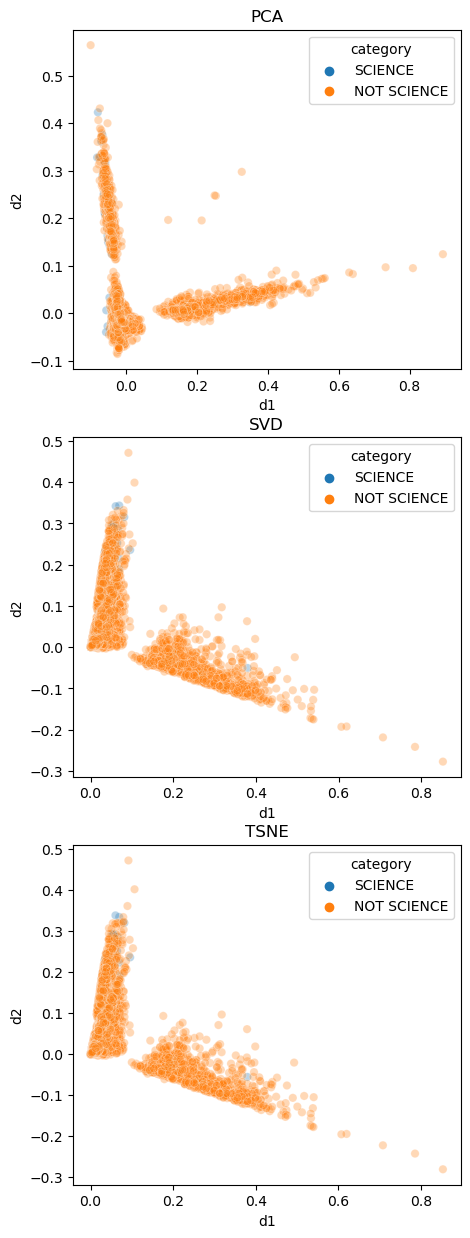

In [25]:
# Visualize Clustering Algorithms
fig, ax = plt.subplots(3,1,figsize=(5,15))
sns.scatterplot(x="d1",y="d2",data=df_pca2D,hue="category",alpha=0.3,ax=ax[0])
sns.scatterplot(x="d1",y="d2",data=df_svd2D,hue="category",alpha=0.3,ax=ax[1])
sns.scatterplot(x="d1",y="d2",data=df_tsne2D,hue="category",alpha=0.3,ax=ax[2])
ax[0].set_title("PCA")
ax[1].set_title("SVD")
ax[2].set_title("TSNE")
plt.show()

In [26]:
# Keep only our training set, and our top 4 classifiers from the previous section
X = tfidf_train
y = im_df_headlines["category"]
y = y[:22040] # keep only the training set

# Define the classifiers
lr = LogisticRegression()
nb = MultinomialNB()
rf = RandomForestClassifier()
svm = SVC()

classifiers = [
    ("Logistic Regression", lr),
    ("Naive Bayes", nb),
    ("Random Forest", rf),
    ("SVM", svm)
]

# Iterate over the pre-defined list of classifiers
conf = []
acc = []
for clf_name, clf in classifiers:    
     
    y_pred = cross_val_predict(clf, X, y, cv = 10, n_jobs = -1)
    conf.append(confusion_matrix(y,y_pred))
    acc.append(accuracy_score(y, y_pred))
    print(clf_name)
    print(classification_report(y, y_pred, labels=np.unique(y_pred)))

Logistic Regression
              precision    recall  f1-score   support

 NOT SCIENCE       0.93      1.00      0.96     19836
     SCIENCE       0.92      0.33      0.49      2204

    accuracy                           0.93     22040
   macro avg       0.92      0.67      0.73     22040
weighted avg       0.93      0.93      0.92     22040

Naive Bayes
              precision    recall  f1-score   support

 NOT SCIENCE       0.91      1.00      0.95     19836
     SCIENCE       0.98      0.13      0.22      2204

    accuracy                           0.91     22040
   macro avg       0.94      0.56      0.59     22040
weighted avg       0.92      0.91      0.88     22040

Random Forest
              precision    recall  f1-score   support

 NOT SCIENCE       0.95      0.99      0.97     19836
     SCIENCE       0.85      0.54      0.66      2204

    accuracy                           0.94     22040
   macro avg       0.90      0.76      0.81     22040
weighted avg       0.94     

/Users/aedanli/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVM
              precision    recall  f1-score   support

 NOT SCIENCE       0.94      0.99      0.97     19836
     SCIENCE       0.90      0.43      0.58      2204

    accuracy                           0.94     22040
   macro avg       0.92      0.71      0.77     22040
weighted avg       0.94      0.94      0.93     22040



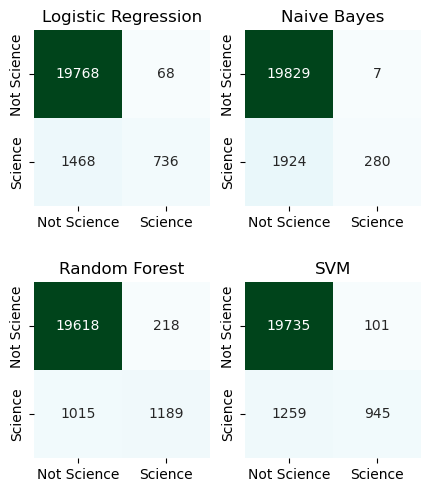

In [27]:
## 1. Logistic Regression, 2. Naive Bayes, 3. Random Forest, and 4. SVM have high accuracy, but low recall
# Plot all confusion matrices
conf_array = pd.DataFrame(np.concatenate(conf, axis=0))
lr_cm = conf_array.iloc[0:2,:]
nb_cm = conf_array.iloc[2:4,:]
rf_cm = conf_array.iloc[4:6,:]
svm_cm = conf_array.iloc[6:8,:]

fig, ax = plt.subplots(2,2,figsize=(5,6))
sns.heatmap(lr_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[0,0])
ax[0,0].set_xticklabels(["Not Science","Science"])
ax[0,0].set_yticklabels(["Not Science","Science"])
ax[0,0].set_title("Logistic Regression")
sns.heatmap(nb_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[0,1])
ax[0,1].set_xticklabels(["Not Science","Science"])
ax[0,1].set_yticklabels(["Not Science","Science"])
ax[0,1].set_title("Naive Bayes")
sns.heatmap(rf_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[1,0])
ax[1,0].set_xticklabels(["Not Science","Science"])
ax[1,0].set_yticklabels(["Not Science","Science"])
ax[1,0].set_title("Random Forest")
sns.heatmap(svm_cm,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn",ax=ax[1,1])
ax[1,1].set_xticklabels(["Not Science","Science"])
ax[1,1].set_yticklabels(["Not Science","Science"])
ax[1,1].set_title("SVM")
plt.show()

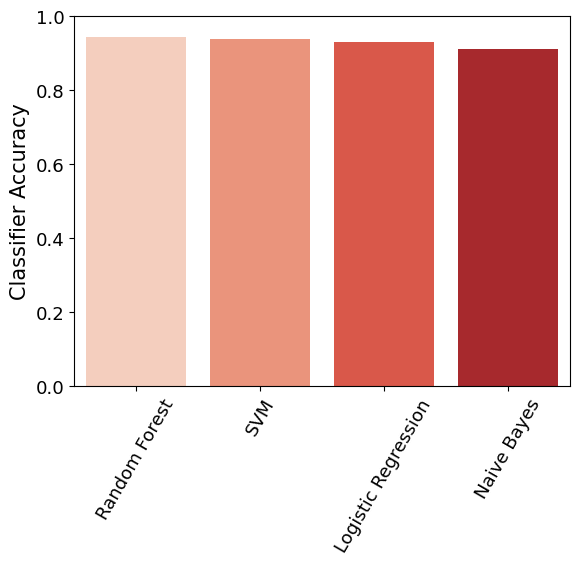

In [28]:
classifiers = [
    "Logistic Regression",
    "Naive Bayes",
    "Random Forest",
    "SVM"
]

acc_df = pd.DataFrame(zip(classifiers,acc),columns=["Classifier","Accuracy"])
acc_df = acc_df.sort_values("Accuracy",ascending=False)

sns.barplot(x="Classifier",y="Accuracy",data=acc_df, palette="Reds")
plt.ylim(0,1)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13,rotation=60)
plt.xlabel("")
plt.ylabel("Classifier Accuracy", fontsize=15)
plt.show()

## 5. Tuning Hyperparameters

Performance dropped substantially with the imbalanced class labels. Let's try tuning the classifiers.
Tune the following class imbalance parameter:
- Resampling Classes

Tune TF-IDF parameters:
- max_features: include only the top features (words) ordered by term frequency across the corpus
- max_df: ignore terms that have a document frequency strictly higher than the given threshold
- min_df: ignore terms that have a document frequency strictly lower than the given threshold

Tune Logistic Regression parameters:
- tol
- C

# 5.1. Equal class weights

In [29]:
## With imbalanced labels, no model works well for the science class. 
# Let's try balancing the class weight, essentially equating the number of samples during training
# note for naive bayes, we need to equate the sample weights intead.
X = tfidf_train
y = im_df_headlines["category"]
y = y[:22040] # keep only the training set

lr = LogisticRegression(class_weight="balanced")
rf = RandomForestClassifier(class_weight="balanced")
svm = SVC(class_weight="balanced")

classifiers = [
    ("Logistic Regression", lr),
    ("Random Forest", rf),
    ("SVM", svm)
]

# Iterate over the pre-defined list of classifiers
conf = []
for clf_name, clf in classifiers:    
     
    y_pred = cross_val_predict(clf, X, y, cv = 10, n_jobs = -1)
    conf.append(confusion_matrix(y,y_pred))
    print(clf_name)
    print(classification_report(y, y_pred, labels=np.unique(y_pred)))

Logistic Regression
              precision    recall  f1-score   support

 NOT SCIENCE       0.97      0.96      0.96     19836
     SCIENCE       0.66      0.74      0.70      2204

    accuracy                           0.94     22040
   macro avg       0.82      0.85      0.83     22040
weighted avg       0.94      0.94      0.94     22040

Random Forest
              precision    recall  f1-score   support

 NOT SCIENCE       0.95      0.99      0.97     19836
     SCIENCE       0.85      0.49      0.62      2204

    accuracy                           0.94     22040
   macro avg       0.90      0.74      0.80     22040
weighted avg       0.94      0.94      0.93     22040



/Users/aedanli/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVM
              precision    recall  f1-score   support

 NOT SCIENCE       0.95      0.99      0.97     19836
     SCIENCE       0.86      0.54      0.66      2204

    accuracy                           0.95     22040
   macro avg       0.90      0.77      0.82     22040
weighted avg       0.94      0.95      0.94     22040



In [30]:
# for the Naive Bayes classifier, we need to instead adjust the sample weights
lb = LabelBinarizer()
y_binary = lb.fit_transform(y)

sample = class_weight.compute_sample_weight("balanced", y)
nb = MultinomialNB()
acc = cross_validate(nb, X, y_binary.ravel(), scoring="f1_macro", cv=10, 
               fit_params={"sample_weight": sample},
               return_train_score = False)
acc = acc["test_score"].mean()
print("F1 macro :{}".format(acc))

F1 macro :0.7646411141094428


### 5.1. TF-IDF - Max features 

In [31]:
## The f1 score of the logistic regression is the best after equalizing class weights
# First, let's try changing the number of tf-idf features

n_features = np.arange(1, 20000, 1000)
lr = LogisticRegression(class_weight="balanced")

accuracy_list = np.empty((0,10), float)
roc_auc = np.empty((0,10), float)
for col in n_features:
    # Construct a TF-IDF matrix for all headlines
    tfidf = TfidfVectorizer(
        lowercase=True,
        max_features=col
    ) 
    tfidf_all = tfidf.fit_transform(im_df_headlines['headline_lemma'].to_numpy())
    tfidf_train = tfidf_all[:22040,:] # keep only the rows corresponding to our labelled data
    X = tfidf_train
    y = im_df_headlines["category"]
    y = y[:22040] # keep only the training set

    scoring = {"acc": "accuracy", "roc_auc": "roc_auc"}
    scores = cross_validate(lr, X, y, scoring=scoring, cv=10)
    
    scores.keys()
    accuracy_list = np.append(accuracy_list, np.array([scores["test_acc"] ]), axis=0)
    roc_auc = np.append(roc_auc, np.array([scores["test_roc_auc"] ]), axis=0)

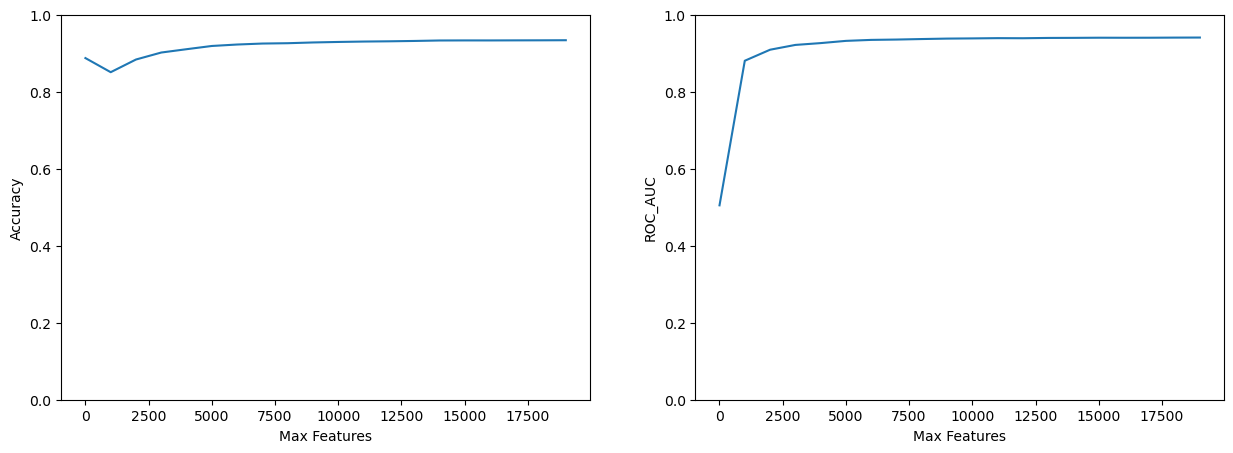

In [32]:
# get mean cross-validation accuracy and ROC_AUc for each max feature. 
# Doesn't seem like tf-idf max features influences classifier results
acc_df = pd.DataFrame(accuracy_list).set_index(n_features)
acc_df = acc_df.mean(axis=1) 

auc_df = pd.DataFrame(roc_auc).set_index(n_features)
auc_df = auc_df.mean(axis=1) 

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(acc_df,ax=ax[0])
sns.lineplot(auc_df,ax=ax[1])
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[0].set_xlabel("Max Features")
ax[1].set_xlabel("Max Features")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("ROC_AUC")
plt.show()

### 5.2. TF-IDF - Min df 

In [33]:
# Check Min-df
min_val = np.linspace(0.0001,0.01,50)
lr = LogisticRegression(class_weight='balanced')

accuracy_list = np.empty((0,10), float)
roc_auc = np.empty((0,10), float)

for col in min_val:
    # Construct a TF-IDF matrix for all headlines
    tfidf = TfidfVectorizer(
        lowercase=True,
        min_df = col
    ) 
    tfidf_all = tfidf.fit_transform(im_df_headlines['headline_lemma'].to_numpy())
    tfidf_train = tfidf_all[:22040,:] # keep only the rows corresponding to our labelled data
    X = tfidf_train
    y = im_df_headlines["category"]
    y = y[:22040] # keep only the training set

    scoring = {"acc": "accuracy",
           "roc_auc": "roc_auc"}
    scores = cross_validate(lr, X, y, scoring=scoring, cv=10)
    scores.keys()
    accuracy_list = np.append(accuracy_list, np.array([scores["test_acc"] ]), axis=0)
    roc_auc = np.append(roc_auc, np.array([scores["test_roc_auc"] ]), axis=0)

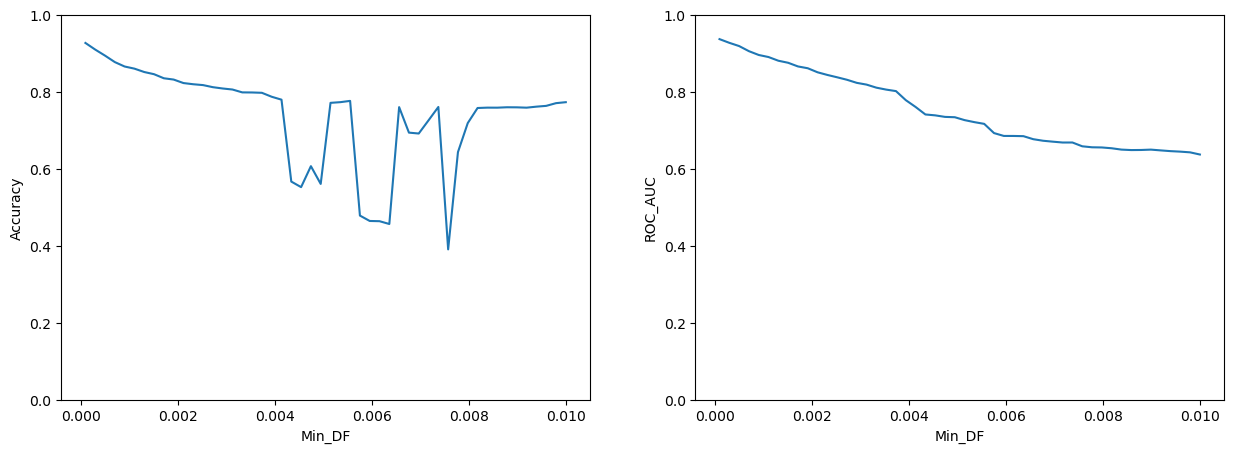

In [34]:
# get mean cross-validation accuracy and ROC_AUc for each max feature. 
# Doesn't seem like tf-idf min features influences classifier results either
acc_df = pd.DataFrame(accuracy_list).set_index(min_val)
acc_df = acc_df.mean(axis=1) 

auc_df = pd.DataFrame(roc_auc).set_index(min_val)
auc_df = auc_df.mean(axis=1) 

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(acc_df,ax=ax[0])
sns.lineplot(auc_df,ax=ax[1])
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[0].set_xlabel("Min_DF")
ax[1].set_xlabel("Min_DF")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("ROC_AUC")
plt.show()


### 5.3. TF-IDF - Max df 

In [35]:
# Check max-df
max_val = np.arange(1,1000,50)
lr = LogisticRegression(class_weight="balanced")

accuracy_list = np.empty((0,10), float)
roc_auc = np.empty((0,10), float)

for col in max_val:
    # Construct a TF-IDF matrix for all headlines
    tfidf = TfidfVectorizer(
        lowercase=True,
        max_df = col
    ) 
    tfidf_all = tfidf.fit_transform(im_df_headlines['headline_lemma'].to_numpy())
    tfidf_train = tfidf_all[:22040,:] # keep only the rows corresponding to our labelled data
    X = tfidf_train
    y = im_df_headlines["category"]
    y = y[:22040] # keep only the training set
    
    scoring = {"acc": "accuracy","roc_auc": "roc_auc"}
    scores = cross_validate(lr, X, y, scoring=scoring, cv=10)
    scores.keys()
    accuracy_list = np.append(accuracy_list, np.array([scores["test_acc"] ]), axis=0)
    roc_auc = np.append(roc_auc, np.array([scores["test_roc_auc"] ]), axis=0)

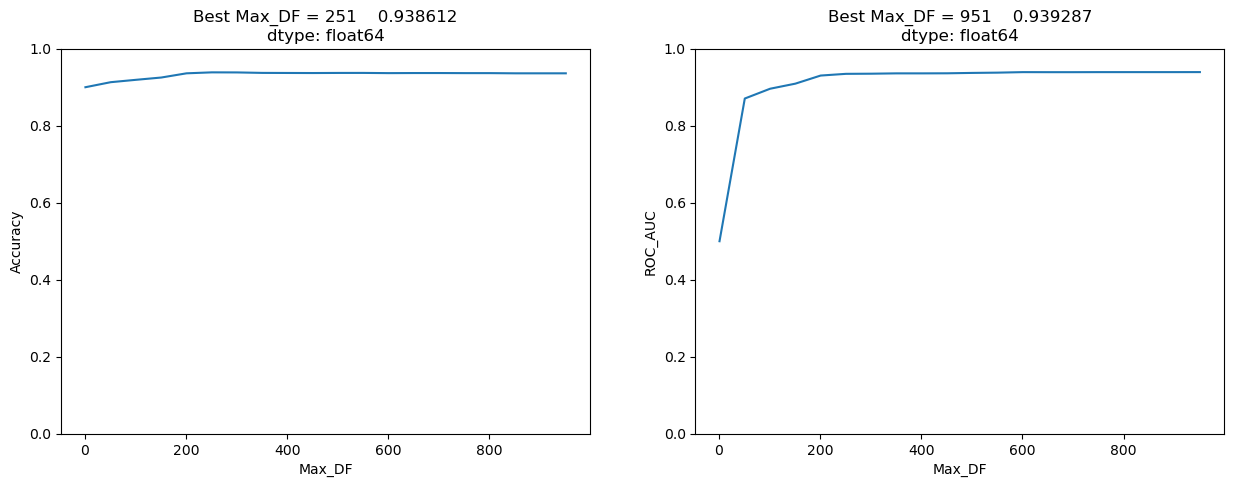

In [36]:
# get mean cross-validation accuracy and ROC_AUc for each max feature. 
# Doesn't seem like tf-idf max features influences classifier results
acc_df = pd.DataFrame(accuracy_list).set_index(max_val)
acc_df = acc_df.mean(axis=1) 
auc_df = pd.DataFrame(roc_auc).set_index(max_val)
auc_df = auc_df.mean(axis=1) 

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(acc_df,ax=ax[0])
sns.lineplot(auc_df,ax=ax[1])
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[0].set_xlabel("Max_DF")
ax[1].set_xlabel("Max_DF")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("ROC_AUC")
ax[0].set_title("Best Max_DF = {}".format(acc_df.nlargest(n=1)))
ax[1].set_title("Best Max_DF = {}".format(auc_df.nlargest(n=1)))
plt.show()

# Test Max_DF = 1 vs Max_DF = 301

### 5.4. Logistic Regression Hyperparameters

In [37]:
## The default tf-idf features are best. Let's instead try to tune logistic regression parameters
# Define params_dt: grid of hyperparameters to search
# The default parameters seem best (from previous analysis)
params_lr = {
             "tol": [0.001,0.005,0.01,0.05,0.1,0.5,1,1.5,2,3,4,5],
             "C": [0.0001,0.005,0.001,0.01,0.01,1,1.5,2,3],
            }
lr = LogisticRegression(class_weight='balanced')

tfidf_all = tfidf.fit_transform(im_df_headlines['headline_lemma'].to_numpy())
tfidf_train = tfidf_all[:22040,:] # keep only the rows corresponding to our labelled data
X = tfidf_train
y = im_df_headlines["category"]
y = y[:22040] # keep only the training set

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=999)

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=lr,
                       param_grid=params_lr,
                       scoring="roc_auc",
                       cv=10,
                       n_jobs=-1)

grid_dt.fit(X_train, y_train)

# Extract the best estimator
best_model = grid_dt.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred = best_model.predict(X_test)

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred) 

# get confusion matrix 
conf = confusion_matrix(y_test,y_pred)

print("Best Parameters: \n{}\n".format(grid_dt.best_params_))
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))
print('Test set Accuracy score: {:.3f}'.format(accuracy))
print(classification_report(y_test, y_pred, labels=np.unique(y_pred)))

Best Parameters: 
{'C': 1.5, 'tol': 0.1}

Test set ROC AUC score: 0.931
Test set Accuracy score: 0.934
              precision    recall  f1-score   support

 NOT SCIENCE       0.97      0.96      0.96      5951
     SCIENCE       0.66      0.70      0.68       661

    accuracy                           0.93      6612
   macro avg       0.81      0.83      0.82      6612
weighted avg       0.94      0.93      0.93      6612



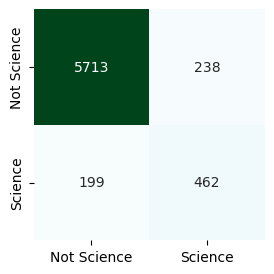

In [45]:
fig, ax = plt.subplots(1,figsize=(3,3))
sns.heatmap(conf,annot=True,square=True,fmt="g",cbar=False,cmap="BuGn")
ax.set_xticklabels(["Not Science","Science"])
ax.set_yticklabels(["Not Science","Science"])
plt.show()

[]

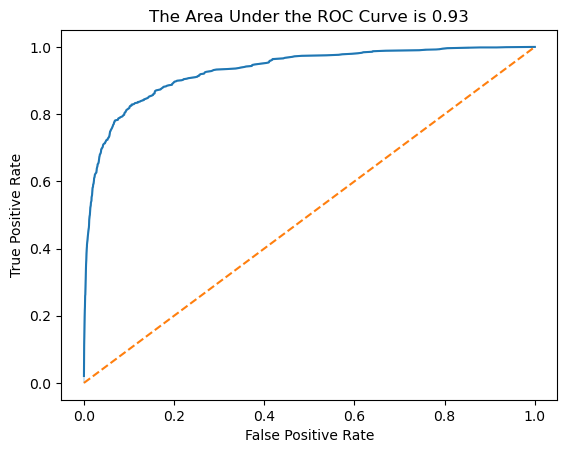

In [39]:
lb = LabelBinarizer()
y_binary = lb.fit_transform(y_test)
# Plot ROC Curve 
fpr, tpr, thresholds = roc_curve(y_binary, y_pred_proba)
roc_auc = roc_auc_score(y_binary, y_pred_proba)

comb = pd.DataFrame(zip(fpr,tpr),columns=["False Positive Rate","True Positive Rate"])

sns.lineplot(x="False Positive Rate",y="True Positive Rate",data=comb)
sns.lineplot(x=[0, 1],y=[0, 1], linestyle='--')
plt.title("The Area Under the ROC Curve is {:.2f}".format(roc_auc))
plt.plot()

In [40]:
## Use the Logistic Regression Classifier to test on our unlabelled dataset
tfidf_all = tfidf.fit_transform(im_df_headlines['headline_lemma'].to_numpy())
tfidf_train = tfidf_all[:22040,:] # keep only the rows corresponding to our labelled data
tfidf_test = tfidf_all[22040:,:]

X_train = tfidf_train
y = im_df_headlines["category"]
y = y[:22040] # keep only the training set
y_train = comb_df["category"]
y_train = y_train[:22040]
X_test = tfidf_test

lr = LogisticRegression(class_weight='balanced')

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

test_df["predict"] = y_pred

In [41]:
science_df = test_df[test_df["predict"] == "SCIENCE"]
science_df = science_df[["headline","link","predict"]]
pd.set_option('display.max_colwidth', None)
science_df.sample(n=10,random_state=999)

,headline,link,predict
3533,Why scientists are also watching animal YouTube videos,https://www.bbc.co.uk/news/science-environment-61609679?at_medium=RSS&at_campaign=KARANGA,SCIENCE
12053,James Webb telescope: Amazing images show the Universe as never before,https://www.bbc.co.uk/news/science-environment-64051171?at_medium=RSS&at_campaign=KARANGA,SCIENCE
12314,Sound Of 2023: Cat Burns went from busking to a platinum record,https://www.bbc.co.uk/news/entertainment-arts-64002162?at_medium=RSS&at_campaign=KARANGA,SCIENCE
1467,Shock result in particle experiment could spark physics revolution,https://www.bbc.co.uk/news/science-environment-60993523?at_medium=RSS&at_campaign=KARANGA,SCIENCE
6403,The mysteries that gave birth to the world’s newest micronation,https://www.bbc.co.uk/news/uk-scotland-62150163?at_medium=RSS&at_campaign=KARANGA,SCIENCE
17076,Watch: Best bits from the Baftas... in 80 seconds,https://www.bbc.co.uk/news/entertainment-arts-65593014?at_medium=RSS&at_campaign=KARANGA,SCIENCE
3639,Universities warn of EU-UK research scheme 'close to precipice',https://www.bbc.co.uk/news/uk-politics-61644662?at_medium=RSS&at_campaign=KARANGA,SCIENCE
13645,Turkey earthquake fault lines mapped from space,https://www.bbc.co.uk/news/science-environment-64603521?at_medium=RSS&at_campaign=KARANGA,SCIENCE
7321,The Hundred: Watch best plays as Welsh Fire face Trent Rockets,https://www.bbc.co.uk/sport/av/cricket/62719241?at_medium=RSS&at_campaign=KARANGA,SCIENCE
13893,Why spy balloons are still useful in era of drones and satellites,https://www.bbc.co.uk/news/world-us-canada-64639407?at_medium=RSS&at_campaign=KARANGA,SCIENCE


In [42]:
not_df = test_df[test_df["predict"] == "NOT SCIENCE"]
not_df = not_df[["headline","link","predict"]]
pd.set_option('display.max_colwidth', None)
not_df.sample(n=10,random_state=999)

,headline,link,predict
10564,World Cup 2022: Alcohol sales banned at World Cup stadiums in Qatar,https://www.bbc.co.uk/sport/football/63674631?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
12425,Shower at home vs at the gym: What’s cheaper?,https://www.bbc.co.uk/news/business-63988095?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
12710,"Masters 2023: Judd Trump beats Barry Hawkins, Stuart Bingham crushes Shaun Murphy",https://www.bbc.co.uk/sport/snooker/64266390?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
9510,Anime: My Neighbour Totoro takes to the Barbican stage,https://www.bbc.co.uk/news/entertainment-arts-63255917?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
8368,Canadian family travel world before children go blind,https://www.bbc.co.uk/news/world-62960970?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
19121,Watch: Explosions and gunfire as BBC reports from Jenin,https://www.bbc.co.uk/news/world-middle-east-66093147?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
1204,Essex Police make 83 arrests as oil terminals blocked,https://www.bbc.co.uk/news/uk-england-essex-60967159?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
15698,Erling Haaland: Manchester City striker called 'monster' as he beats season scoring record,https://www.bbc.co.uk/sport/football/65243884?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
8016,Queen Elizabeth II: 'You could feel the love everyone has',https://www.bbc.co.uk/news/uk-62913032?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE
8637,Can electrical stimulation improve your gym workout?,https://www.bbc.co.uk/news/business-62887379?at_medium=RSS&at_campaign=KARANGA,NOT SCIENCE


# 6. Identify most common words in each class using LDA

In [46]:
## Run LDA to visualize text topics
tfidf = TfidfVectorizer(lowercase=True)
tfidf_all = tfidf.fit_transform(im_df_headlines['headline_lemma'].to_numpy())
tfidf_train = tfidf_all[:22040,:] # keep only the rows corresponding to our labelled data
tfidf_test = tfidf_all[22040:,:] # keep only the rows corresponding to training set

feature_names = tfidf.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=2, random_state=999)

In [48]:
## on training set only
lda.fit(tfidf_train)
n_topwords = 10
topwords = dict()
for id, topic in enumerate(lda.components_):
    print("Topic %d:" % (id))
    words = []
    # get the most common words for each topic, need [::-1] to sort the array in descending order
    for i in topic.argsort()[::-1][:n_topwords]:
        words.append(feature_names[i])
    print(words)
    topwords[id] = words

Topic 0:
['photo', 'new', 'video', 'way', 'life', 'good', 'change', 'thing', 'day', 'week']
Topic 1:
['trump', 'donald', 'new', 'year', 'photo', 'want', 'need', 'clinton', 'health', 'gop']


# 7. Future Directions

1. Use the full dataset, increase the imbalance to 1:100
2. Classify based on article description rather than headline, which might be too short
3. Try multi-class classification
4. Try neural networks 